<a href="https://colab.research.google.com/github/charlesellis1/trump/blob/main/Skipgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install keras
!pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re

#Our data is available and is accessed from the mydata folder. This function 
# prints the content of this folder, and we can make sure our csv file is in there.
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Data144'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Data144/tweets-11-06-2020.csv


In [ ]:
#Read CSV for Trump tweets

data = pd.read_csv("/content/drive/MyDrive/Data144/tweets-11-06-2020.csv").dropna()

In [ ]:
# data['year'] = pd.DatetimeIndex(data['date']).year
# data['month'] = pd.DatetimeIndex(data['date']).month
# data['day'] = pd.DatetimeIndex(data['date']).day

# data.sort_values(['year', 'month', 'day'])

In [ ]:
data.columns

Index(['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites',
       'retweets', 'date'],
      dtype='object')

In [ ]:
#Change t/f's to 0s and 1s. Run one time!
data['isRetweet'] = (data['isRetweet'] == 't').astype(int)
data['isDeleted'] = (data['isDeleted'] == 't').astype(int)
data.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,0,0,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,0,0,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,1,0,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,0,0,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,1,0,Twitter for iPhone,0,9081,2020-01-17 13:13:59


In [ ]:
#We want to use just tweets sent by Trump, so let's eliminate Retweets
nonrt_tweets = data[data['isRetweet'] == 0]
nonrt_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,0,0,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,0,0,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,0,0,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
6,1315779944002199552,"“I’m running as a proud Democrat, for the Sena...",0,0,Twitter for iPhone,149007,34897,2020-10-12 22:22:39
7,1223640662689689602,Getting a little exercise this morning! https:...,0,0,Twitter for iPhone,285863,30209,2020-02-01 16:14:02


In [ ]:
nonrt_tweets['text_non_url'] = nonrt_tweets['text'].str.replace(r"http\S+", "", regex=True)
nonrt_tweets['text_new'] = nonrt_tweets['text_non_url'].replace(r'^\s*$', np.nan, regex=True)
nonrt_tweets = nonrt_tweets.drop(columns={'text', 'text_non_url'}).dropna()
nonrt_tweets.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,isRetweet,isDeleted,device,favorites,retweets,date,text_new
0,98454970654916608,0,0,TweetDeck,49,255,2011-08-02 18:07:48,Republicans and Democrats have both created ou...
1,1234653427789070336,0,0,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,I was thrilled to be back in the Great city of...
3,1304875170860015617,0,0,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,The Unsolicited Mail In Ballot Scam is a major...


In [ ]:
nonrt_tweets['year'] = pd.DatetimeIndex(nonrt_tweets['date']).year
nonrt_tweets['month'] = pd.DatetimeIndex(nonrt_tweets['date']).month
nonrt_tweets['hour'] = pd.DatetimeIndex(nonrt_tweets['date']).hour

In [ ]:
trump_data_2016 = nonrt_tweets[nonrt_tweets['year'] >= 2016]
trump_data_2016.head()

,id,isRetweet,isDeleted,device,favorites,retweets,date,text_new,year,month,hour
1,1234653427789070336,0,0,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,I was thrilled to be back in the Great city of...,2020,3,1
3,1304875170860015617,0,0,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,The Unsolicited Mail In Ballot Scam is a major...,2020,9,20
6,1315779944002199552,0,0,Twitter for iPhone,149007,34897,2020-10-12 22:22:39,"“I’m running as a proud Democrat, for the Sena...",2020,10,22
7,1223640662689689602,0,0,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,Getting a little exercise this morning!,2020,2,16
15,1215247978966986752,0,0,Twitter for iPhone,48510,11608,2020-01-09 12:24:31,Thank you Elise!,2020,1,12


In [ ]:
#Make skip gram
!pip install gensim
import gensim

In [ ]:
import string
import pprint
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
import random
from gensim import corpora, models, similarities
import nltk
from nltk import word_tokenize, tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
trump_data_2016 = trump_data_2016.sort_values(['year', 'month', 'hour'])
trump_data_2016.head()

,id,isRetweet,isDeleted,device,favorites,retweets,date,text_new,year,month,hour
41369,692864417101287425,0,0,Twitter for iPhone,6738,1900,2016-01-29 00:18:44,"Watching biased Charles @krauthammer, a @FoxNe...",2016,1,0
41541,690337376061788161,0,0,Twitter for iPhone,4482,1903,2016-01-22 00:57:10,"Thank you, Iowa! #FITN #IACaucus#MakeAmericaGr...",2016,1,0
41542,690336644281581568,0,0,Twitter for iPhone,4111,1255,2016-01-22 00:54:16,"Why does @Greta have a fired Bushy like dummy,...",2016,1,0
41601,688517545293406208,0,0,Twitter for iPhone,5152,2296,2016-01-17 00:25:49,Interesting read from Peggy Noonan.,2016,1,0
41643,687436400958947328,0,0,Twitter for iPhone,4658,1178,2016-01-14 00:49:44,.@EricTrump- unbelievable job on #FoxNews with...,2016,1,0


In [ ]:
smart = [d in ['Twitter for iPhone','Twitter for Android'] for d in trump_data_2016['device']]
trump = trump_data_2016[smart]
tweet_list = list(trump['text_new'])

In [ ]:
#number of chars
txt_file = ""
for tweet in tweet_list:
  txt_file += tweet + " "
len(txt_file)

2783711

In [ ]:
with open('tweets.txt','w') as f:
  f.write(txt_file)

In [ ]:
#load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
#load text
raw_text = load_doc('tweets.txt')
raw_text = raw_text.lower()
print(len(raw_text))

2783711


In [ ]:
#Problem is here... why does my number go down to 3814??

pattern = r'''(?x)  # set flag to allow verbose regexps
(?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
|\w+(?:[-']\w+)*    # words with optional internal hyphens
|\$?\d+(?:\.\d+)?   # currency, e.g. $12.80 
|\.\.\.             # elipses
|[.,;"'?()-_`]      # these are separate tokens
'''
tokenized_raw = " ".join(nltk.regexp_tokenize(raw_text, pattern))
print(len(tokenized_raw))
tokenized_raw = tokenize.sent_tokenize(tokenized_raw)
print(len(tokenized_raw))
tokenized_raw[:15]

2828960
28754


["watching biased charles @ krauthammer , a @ foxnews flunky who didn't know that i won every debate , in particular - the last one .",
 'check polls thank you , iowa fitn iacaucus makeamericagreatagain trump2016 why does @ greta have a fired bushy like dummy , john sununu on - spewing false info ?',
 'i will beat hillary by a lot , she wants no part of trump .',
 'interesting read from peggy noonan .',
 '.',
 '@ erictrump - unbelievable job on foxnews with @ greta .',
 'that was better than i could do trump2016 thank you to our law enforcement officers lesm trump2016 i want to thank the people of iowa for an unbelievable day .',
 'the crowds were amazing .',
 'will be back tuesday will be on meet the press with @ chucktodd tomorrow morning .',
 'enjoy i will be interviewed by chris wallace on fox tomorrow morning .',
 'tune in i am in new hampshire .',
 'just received great news from reuters poll .',
 'thank you for your support " " " @ icareeguns : this iowan is voting for @ realdona

In [ ]:
#Remove punctuations
nopunct = []
for tweet in tokenized_raw:
    a = [w for w in tweet.split() if w not in string.punctuation]
    nopunct.append(" ".join(a))

In [ ]:
tok_corp = [nltk.word_tokenize(sent) for sent in nopunct]
tok_corp

[['watching',
  'biased',
  'charles',
  'krauthammer',
  'a',
  'foxnews',
  'flunky',
  'who',
  'did',
  "n't",
  'know',
  'that',
  'i',
  'won',
  'every',
  'debate',
  'in',
  'particular',
  'the',
  'last',
  'one'],
 ['check',
  'polls',
  'thank',
  'you',
  'iowa',
  'fitn',
  'iacaucus',
  'makeamericagreatagain',
  'trump2016',
  'why',
  'does',
  'greta',
  'have',
  'a',
  'fired',
  'bushy',
  'like',
  'dummy',
  'john',
  'sununu',
  'on',
  'spewing',
  'false',
  'info'],
 ['i',
  'will',
  'beat',
  'hillary',
  'by',
  'a',
  'lot',
  'she',
  'wants',
  'no',
  'part',
  'of',
  'trump'],
 ['interesting', 'read', 'from', 'peggy', 'noonan'],
 [],
 ['erictrump', 'unbelievable', 'job', 'on', 'foxnews', 'with', 'greta'],
 ['that',
  'was',
  'better',
  'than',
  'i',
  'could',
  'do',
  'trump2016',
  'thank',
  'you',
  'to',
  'our',
  'law',
  'enforcement',
  'officers',
  'lesm',
  'trump2016',
  'i',
  'want',
  'to',
  'thank',
  'the',
  'people',
  'of'

In [ ]:
unique_words = list(set([item for sublist in tok_corp for item in sublist]))
len(unique_words)

# I feel like I should have wayy more than this

17999

In [ ]:
#Create model
model = gensim.models.Word2Vec(tok_corp, min_count=1, size=300, window=5)

In [ ]:
rel1 = model.similarity('fake', 'news')
rel2 = model.similarity('joe', 'sleepy')
rel3 = model.similarity('china', 'virus')
rel4 = model.similarity('corrupt', 'media')
rel5 = model.similarity('biden', 'great')

print(rel1)
print(rel2)
print(rel3)
print(rel4)
print(rel5)

0.32562384
0.96390843
0.6463731
0.9391609
0.032967195


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-

In [ ]:
closest1 = model.most_similar(positive=['joe', 'woman'], negative=['man'], topn=5)
closest2 = model.most_similar(positive=['election', 'fraud'], negative=['vote'], topn=5)
closest3 = model.most_similar('virus', topn=5)
closest4 = model.most_similar('melania', topn=5)
closest5 = model.most_similar(positive=['soldier', 'terror'], negative=['american'], topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/pyt

In [ ]:
print(closest1)
print(closest2)
print(closest3)
print(closest4)
print(closest5)

[('sleepy', 0.927393913269043), ('biden', 0.8911363482475281), ('softball', 0.8845665454864502), ('digenova', 0.8815015554428101), ('hiden', 0.8808721303939819)]
[('hoax', 0.8616014719009399), ('continuation', 0.8583626747131348), ('despite', 0.8396248817443848), ('rigged', 0.8390347361564636), ('perpetrated', 0.8383811712265015)]
[('antifa', 0.9568806886672974), ('similar', 0.9523305892944336), ('boys', 0.9520747661590576), ('greats', 0.9467923641204834), ("lyin'ted", 0.9460942149162292)]
[('flotus', 0.9874976277351379), ('erictrump', 0.9682018756866455), ('west', 0.9627647399902344), ('hershey', 0.9608262777328491), ('pledge', 0.9585405588150024)]
[('plead', 0.9319602251052856), ('admitted', 0.9318375587463379), ('lightweight', 0.9272584915161133), ('60minutes', 0.9246718883514404), ('moderator', 0.9242405891418457)]


In [ ]:
match1 = model.doesnt_match('scam hoax covid hillary impeachment'.split())
match2 = model.doesnt_match('hillary kamala pelosi pence obama'.split())
match3 = model.doesnt_match('radical dems left looting terrible thank'.split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated

In [ ]:
print(match1)
print(match2)
print(match3)

hillary
pence
thank


In [ ]:
word_vectors = model.wv

In [ ]:
word_vectors.vocab

{'watching': <gensim.models.keyedvectors.Vocab at 0x7f36c58f1f98>,
 'biased': <gensim.models.keyedvectors.Vocab at 0x7f36c58f7048>,
 'charles': <gensim.models.keyedvectors.Vocab at 0x7f369bb66978>,
 'krauthammer': <gensim.models.keyedvectors.Vocab at 0x7f369bb668d0>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7f369bb66a20>,
 'foxnews': <gensim.models.keyedvectors.Vocab at 0x7f369bb66a58>,
 'flunky': <gensim.models.keyedvectors.Vocab at 0x7f369bb66a90>,
 'who': <gensim.models.keyedvectors.Vocab at 0x7f369bb66ac8>,
 'did': <gensim.models.keyedvectors.Vocab at 0x7f369bb66b00>,
 "n't": <gensim.models.keyedvectors.Vocab at 0x7f369bb66b38>,
 'know': <gensim.models.keyedvectors.Vocab at 0x7f369bb66b70>,
 'that': <gensim.models.keyedvectors.Vocab at 0x7f369bb66ba8>,
 'i': <gensim.models.keyedvectors.Vocab at 0x7f369bb66be0>,
 'won': <gensim.models.keyedvectors.Vocab at 0x7f369bb66c18>,
 'every': <gensim.models.keyedvectors.Vocab at 0x7f369bb66c50>,
 'debate': <gensim.models.keyedvectors.Voca

In [ ]:
df = pd.DataFrame()
for i in word_vectors.vocab:
  df[i] = word_vectors[i]

In [ ]:
from sklearn.cluster import KMeans
array = np.array(df.T)
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df.T.index.values
cluster_map['cluster'] = kmeans.labels_

In [ ]:
word_list = []
for i in word_vectors.vocab:
  word_list.append(word_vectors[i])

In [ ]:
np.array(word_list).shape

(17999, 300)

In [ ]:
from sklearn.manifold import TSNE

# Lets dim reduce the 16 dimension vectors to 2 dimensions to vizualise the dataset 
data_embed_GOOG=TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(word_list)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 17999 samples in 0.862s...
[t-SNE] Computed neighbors for 17999 samples in 166.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17999
[t-SNE] Computed conditional probabilities for sample 2000 / 17999
[t-SNE] Computed conditional probabilities for sample 3000 / 17999
[t-SNE] Computed conditional probabilities for sample 4000 / 17999
[t-SNE] Computed conditional probabilities for sample 5000 / 17999
[t-SNE] Computed conditional probabilities for sample 6000 / 17999
[t-SNE] Computed conditional probabilities for sample 7000 / 17999
[t-SNE] Computed conditional probabilities for sample 8000 / 17999
[t-SNE] Computed conditional probabilities for sample 9000 / 17999
[t-SNE] Computed conditional probabilities for sample 10000 / 17999
[t-SNE] Computed conditional probabilities for sample 11000 / 17999
[t-SNE] Computed conditional probabilities for sample 12000 / 17999
[t-SNE] Computed conditional probabilities for 

In [ ]:
#change data_embed_goog to trump tag
df_tsv = pd.DataFrame()
for i in range(0, len(unique_words)):
  df_tsv[unique_words[i]] = data_embed_GOOG[i]

In [ ]:
df_tsv_2 = df_tsv.T
array_kmeans = np.array(df_tsv_2)
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(array_kmeans)
df_tsv_2['cluster'] = kmeans.labels_
df_tsv_2['word'] = df_tsv_2.index
df_tsv_2.rename(columns={0:'x', 1:"y", 'cluster':'feature 1', 'word': 'feature 2'}, inplace=True)

In [ ]:
df_tsv_2

,x,y,feature 1,feature 2
prople,-45.681969,29.861626,2,prople
blah,-38.519772,29.325869,2,blah
debfisher,-46.009121,13.022483,18,debfisher
factory,-29.844309,-25.203487,10,factory
ghani,-56.958115,27.354729,12,ghani
...,...,...,...,...
walker,-10.076161,-17.232643,0,walker
detailed,-9.890557,-17.394691,0,detailed
redacting,18.419270,3.923373,15,redacting
burden,10.148297,-10.484537,3,burden


In [ ]:
df_tsv_2.to_csv('trump_3.tsv', sep='\t', index=False)

In [ ]:
from google.colab.output import eval_js
from IPython.display import Javascript

In [ ]:
!git clone https://github.com/CAHLR/d3-scatterplot.git

Cloning into 'd3-scatterplot'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1022 (delta 9), reused 1 (delta 0), pack-reused 1003
Receiving objects: 100% (1022/1022), 1.94 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (590/590), done.


In [ ]:
def show_port(port, data_file, width=600, height=800):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'trump_3.tsv'
height = 1600

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

In [ ]:
#adding hashtags column that contains the hashtags of each tweet
trump_data_2016['tag'] = trump_data_2016['text_new'].apply(lambda x: re.findall(r"@(\w+)", x))
trump_data_2016.head(35)

,id,isRetweet,isDeleted,device,favorites,retweets,date,text_new,year,month,hour,tag
41369,692864417101287425,0,0,Twitter for iPhone,6738,1900,2016-01-29 00:18:44,"Watching biased Charles @krauthammer, a @FoxNe...",2016,1,0,"[krauthammer, FoxNews]"
41541,690337376061788161,0,0,Twitter for iPhone,4482,1903,2016-01-22 00:57:10,"Thank you, Iowa! #FITN #IACaucus#MakeAmericaGr...",2016,1,0,[]
41542,690336644281581568,0,0,Twitter for iPhone,4111,1255,2016-01-22 00:54:16,"Why does @Greta have a fired Bushy like dummy,...",2016,1,0,[Greta]
41601,688517545293406208,0,0,Twitter for iPhone,5152,2296,2016-01-17 00:25:49,Interesting read from Peggy Noonan.,2016,1,0,[]
41643,687436400958947328,0,0,Twitter for iPhone,4658,1178,2016-01-14 00:49:44,.@EricTrump- unbelievable job on #FoxNews with...,2016,1,0,"[EricTrump, greta]"
41680,686337471123197952,0,0,Twitter for iPhone,7921,2942,2016-01-11 00:02:59,Thank you to our law enforcement officers! #LE...,2016,1,0,[]
41691,685977617145663492,0,0,Twitter for iPhone,5371,1509,2016-01-10 00:13:03,I want to thank the people of Iowa for an unbe...,2016,1,0,[]
41692,685977534983462912,0,0,Twitter for iPhone,3150,882,2016-01-10 00:12:43,Will be on Meet the Press with @ChuckTodd tomo...,2016,1,0,[ChuckTodd]
41693,685977438527078400,0,0,Twitter for iPhone,3617,994,2016-01-10 00:12:20,I will be interviewed by Chris Wallace on Fox ...,2016,1,0,[]
41747,684531959939371008,0,0,Twitter for iPhone,9817,3606,2016-01-06 00:28:31,I am in New Hampshire. Just received great new...,2016,1,0,[]


In [ ]:
#twitter-preprocessing package
!pip install tweet-preprocessor
import preprocessor as p

In [ ]:
#installing ekphrasis
!pip install ekphrasis

In [ ]:
#seperates words from multiple word hashtags, learned from a twitter corpus 
from ekphrasis.classes.segmenter import Segmenter
#segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus='twitter')


Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [ ]:
tags = []
for tag in trump_data_2016['tag']:
  if len(tag) == 1:
    tags += tag
  elif len(tag) > 1:
    for t in tag:
      tags += [t]


In [ ]:
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
fdist = FreqDist(tags)

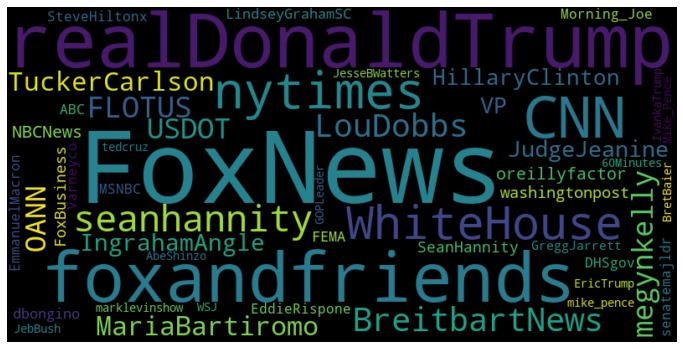

<Figure size 432x288 with 0 Axes>

In [ ]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('tag_wc.png')